# Prophet


## Dependencies


In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools 
from utils import create_session, mape

from statsmodels.tsa.seasonal import STL


# model
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics


# Snowflake
from snowflake.snowpark import Session

## Data Exploration

First, retrieve the desired data

In [46]:
session = create_session()

df = session.table("company_revenue_time_series_1") # with cutoff
df = df.to_pandas()

df = df.rename(columns={'DATE': 'ds', 'REVENUE': 'y'})
df = df[['ds', 'y']] # drop everything but these two if there are any

df['ds'] = pd.to_datetime(df['ds'])
df = df.sort_values(by='ds')
df = df.reset_index(drop=True)

print(df.head())
print('-'*60)
print(df.info())

          ds          y
0 2012-03-02  137233.99
1 2012-03-03  190247.55
2 2012-03-04  197809.12
3 2012-03-05  125417.64
4 2012-03-06  120953.92
------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 364 entries, 0 to 363
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      364 non-null    datetime64[ns]
 1   y       364 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 5.8 KB
None


#### Checking for 0 and NA values

In [8]:
zero_counts = (df == 0).sum()
print("Number of zeros in each column:\n", zero_counts)

na_counts = df.isna().sum()
print("\nNumber of NaN values in each column:\n", na_counts)

Number of zeros in each column:
 ds    0
y     0
dtype: int64

Number of NaN values in each column:
 ds    0
y     0
dtype: int64


#### Checking for missing dates

In [9]:
all_dates = pd.date_range(start=df['ds'].min(), end=df['ds'].max(), freq='D')
missing_dates = all_dates.difference(df['ds'])

print("Missing dates:\n", missing_dates)

Missing dates:
 DatetimeIndex([], dtype='datetime64[ns]', freq='D')


#### Handling outliers

Based on previous experiments I have decided to use a z score of 2 and replace the outliers with the mean.

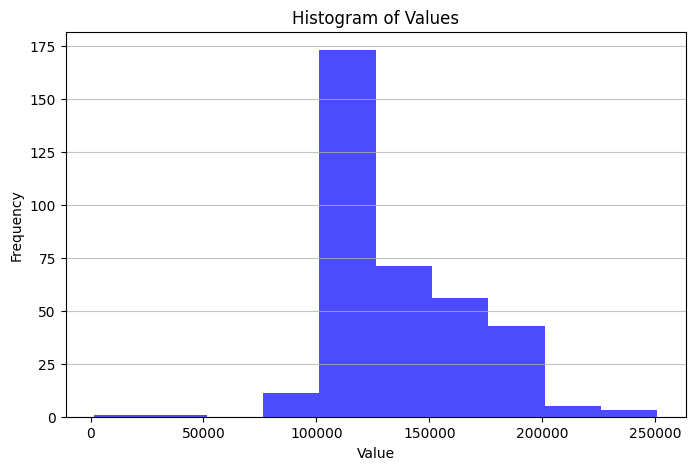

In [10]:
plt.figure(figsize=(8, 5))
plt.hist(df['y'], bins=10, color='blue', alpha=0.7)
plt.title('Histogram of Values')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [47]:
mean = df['y'].mean()
std = df['y'].std()

z_scores = (df['y'] - mean) / std

threshold = 2
outlier_index = np.where(z_scores > threshold)[0]

print(f"Setting "+str(len(outlier_index)) + " rows equal to the mean: {mean}.")

df['y'] = np.where(np.abs(z_scores) > threshold, mean, df['y'])

df.info()
df.head()

Setting 10 rows equal to the mean: {mean}.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 364 entries, 0 to 363
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      364 non-null    datetime64[ns]
 1   y       364 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 5.8 KB


,ds,y
0,2012-03-02,137233.99
1,2012-03-03,190247.55
2,2012-03-04,197809.12
3,2012-03-05,125417.64
4,2012-03-06,120953.92


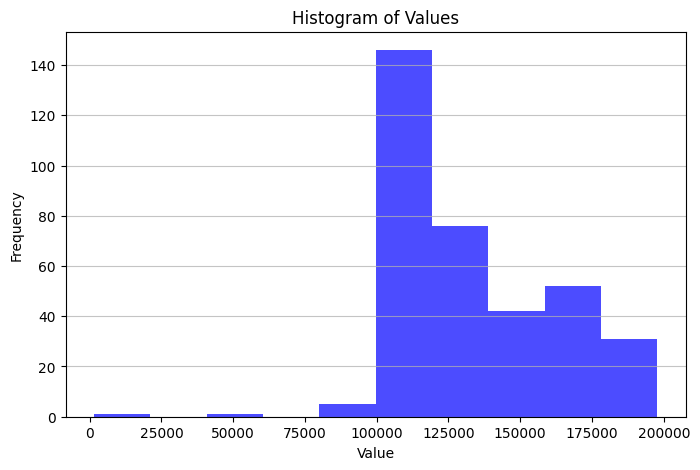

In [12]:
plt.figure(figsize=(8, 5))
plt.hist(df['y'], bins=10, color='blue', alpha=0.7)
plt.title('Histogram of Values')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

Checking trend, seasonality, and residual

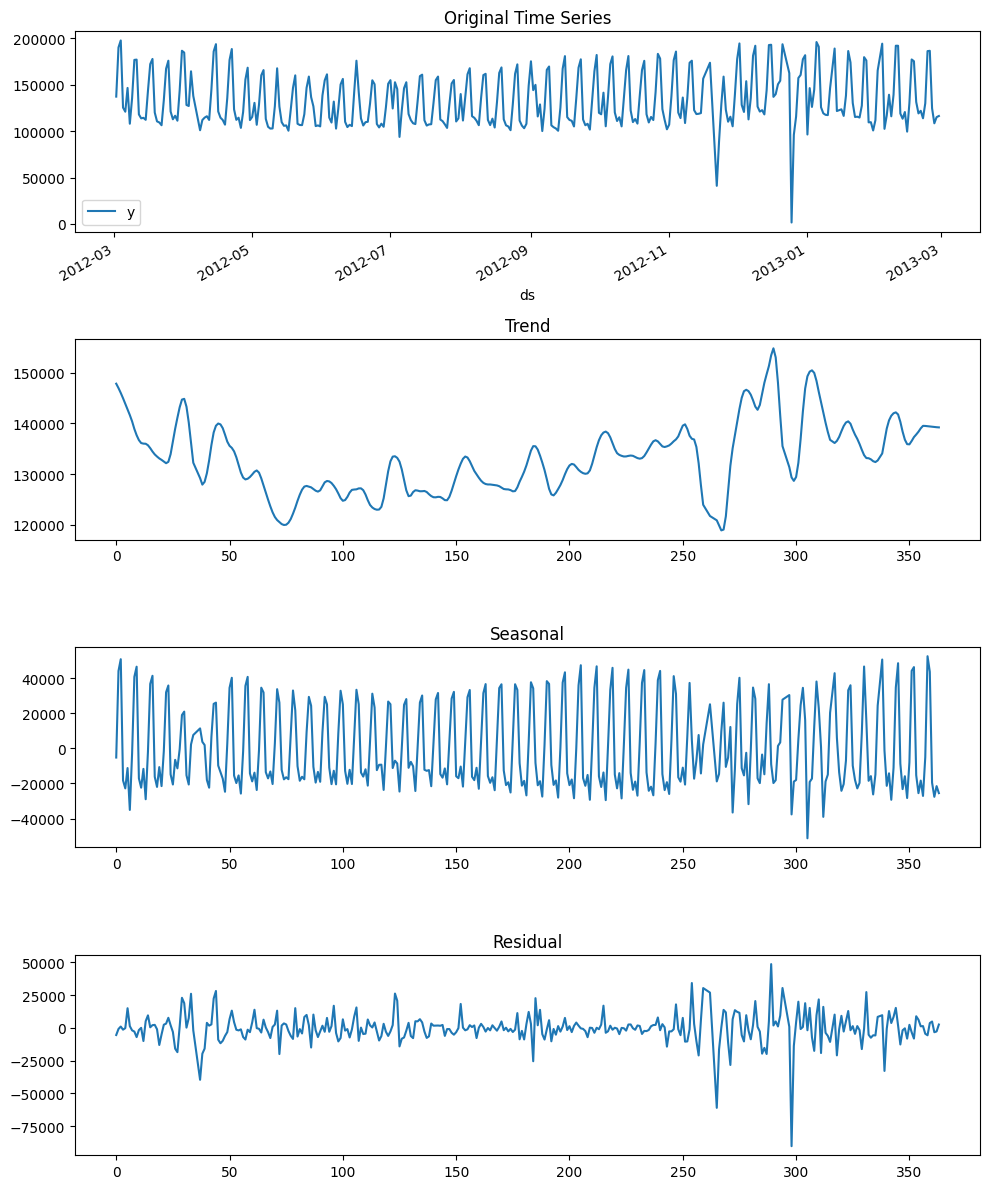

In [15]:
stl = STL(df['y'], period=7)  # Set period=12 for monthly data
result = stl.fit()

# Plot the decomposition
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, figsize=(10, 12))

df.plot(x='ds', ax=ax1)
ax1.set_title('Original Time Series')

ax2.plot(result.trend)
ax2.set_title('Trend')

ax3.plot(result.seasonal)
ax3.set_title('Seasonal')

ax4.plot(result.resid)
ax4.set_title('Residual')

plt.tight_layout()
plt.show()

## Hyperparameter tuning

From the plots above we can see that there is a weekly seasonal component and that the trend is linear. Hence these values are predetermined.

In [ ]:
changepoint_prior_scale_range = np.linspace(0.001, 0.5, num=5).tolist()
seasonality_prior_scale_range = np.linspace(0.01, 10, num=5).tolist()
param_grid = {  
    "changepoint_prior_scale": changepoint_prior_scale_range,
    "seasonality_prior_scale": seasonality_prior_scale_range,
    "seasonality_mode": ['additive', 'multiplicative'],
    'changepoint_range': [0.8, 0.9, 0.95]}
    

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
print(f"number of different param_grids: {len(all_params)}")
mapes = [] 


for params in all_params:
    params["weekly_seasonality"] = True
    params["growth"] = "linear"

    m = Prophet(**params).fit(df)  
    df_cv = cross_validation(m, initial="230 days", period="15 days", horizon = "15 days", disable_tqdm=True)
    df_p = performance_metrics(df_cv, rolling_window=1)
    mapes.append(df_p["mape"].values[0])

tuning_results = pd.DataFrame(all_params)
tuning_results["mape"] = mapes
    

params_dict = dict(tuning_results.sort_values("mape").reset_index(drop=True).iloc[0]) #select best
print('-'*60)
print(params_dict)

In [76]:
# Optimal parameters
params_dict = {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 5.005, 'seasonality_mode': 'additive', 'changepoint_range': 0.8, 'weekly_seasonality': True, 'growth': 'linear', 'mape': 0.7848000343208108}

## Fitting model forecasting

In [71]:
if 'mape' in params_dict.keys():
    params_dict.pop('mape')

model = Prophet(
    **params_dict
)
model.add_country_holidays(country_name='US')

model.fit(df)

10:19:54 - cmdstanpy - INFO - Chain [1] start processing
10:19:54 - cmdstanpy - INFO - Chain [1] done processing
10:19:54 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:19:54 - cmdstanpy - INFO - Chain [1] start processing


            ds          y
0   2012-03-02  137233.99
1   2012-03-03  190247.55
2   2012-03-04  197809.12
3   2012-03-05  125417.64
4   2012-03-06  120953.92
..         ...        ...
359 2013-02-24  186628.58
360 2013-02-25  124662.95
361 2013-02-26  108440.70
362 2013-02-27  115084.81
363 2013-02-28  116328.96

[364 rows x 2 columns]


10:19:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/8 [00:00<?, ?it/s]10:20:35 - cmdstanpy - INFO - Chain [1] start processing
10:20:35 - cmdstanpy - INFO - Chain [1] done processing
10:20:35 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:20:35 - cmdstanpy - INFO - Chain [1] start processing
10:20:35 - cmdstanpy - INFO - Chain [1] done processing
 12%|█▎        | 1/8 [00:00<00:02,  3.33it/s]10:20:35 - cmdstanpy - INFO - Chain [1] start processing
10:20:35 - cmdstanpy - INFO - Chain [1] done processing
10:20:35 - cmdstanpy - INFO - Chain [1] start processing
10:20:35 - cmdstanpy - INFO - Chain [1] done processing
 38%|███▊      | 3/8 [00:00<00:00,  8.67it/s]10:20:35 - cmdstanpy - INFO - Chain [1] start processing
10:20:35 - cmdstanpy - INFO - Chain [1] done processing
10:20:35 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newt

Perforamnce metrics:
   horizon           mse          rmse           mae      mape     mdape  \
0   2 days  4.719023e+08  21723.311591  17291.378506  0.122684  0.126335   
1   3 days  4.218098e+08  20538.008313  18369.113459  0.129975  0.150437   
2   4 days  7.515733e+08  27414.836924  22221.310087  0.148485  0.131700   
3   5 days  8.037459e+08  28350.412222  23275.677951  0.152353  0.156839   
4   6 days  7.321900e+08  27059.009505  21634.189159  0.144691  0.119506   
5   7 days  5.359363e+08  23150.297554  18619.163074  0.130362  0.126514   
6   8 days  4.359026e+08  20878.281028  16511.541500  0.132717  0.106822   
7   9 days  4.862271e+08  22050.558851  15377.214858  0.111916  0.058495   
8  10 days  2.826628e+08  16812.578204  12670.895899  0.086397  0.064223   
9  11 days  2.171777e+08  14736.950881  13343.356923  0.097768  0.101380   
10 12 days  1.579389e+08  12567.372528  11380.832064  0.082395  0.063935   
11 13 days  2.143570e+08  14640.935040  11736.834413  0.087175  0.0

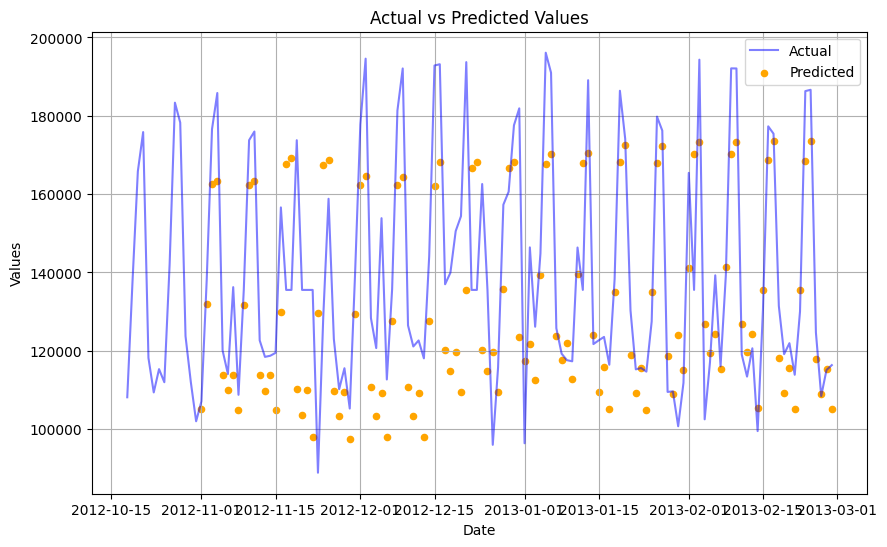

120
120
Total MAPE: 11.24%


In [73]:
df_cv = cross_validation(model, 
                         initial='230 days',  # Training set size
                         period='15 days',    # Cutoff frequency
                         horizon='15 days')   # Forecast horizon

df_performance = performance_metrics(df_cv)
print(f"Perforamnce metrics:\n{df_performance}")

# Plot the forecast
plt.figure(figsize=(10, 6))
plt.plot(df['ds'][230:], df['y'][230:], label='Actual', color='blue', alpha=0.5)
plt.scatter(df_cv['ds'], df_cv['yhat'], label='Predicted', color='orange', s=20)

plt.title('Actual vs Predicted Values')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.grid()
plt.show()


actual_values = df_cv['y']
predicted_values = df_cv['yhat']

print(len(predicted_values))

total_mape = mape(actual_values, predicted_values)
print(len(predicted_values))
print(f'Total MAPE: {total_mape}%')

## Train / test, instead of cross validation

10:07:09 - cmdstanpy - INFO - Chain [1] start processing
10:07:09 - cmdstanpy - INFO - Chain [1] done processing


Total MAPE: 10.37%


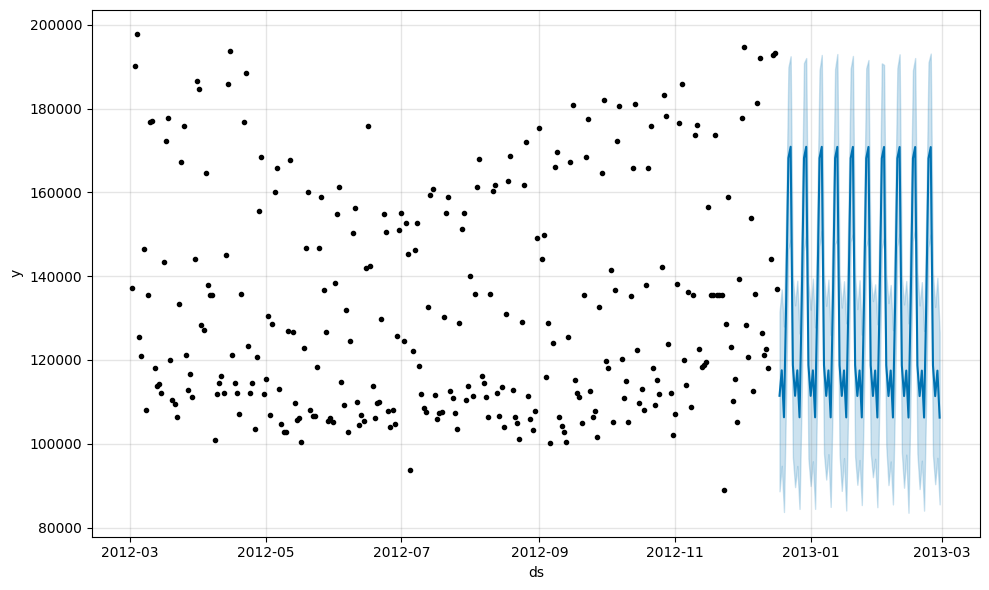

In [50]:
cutoff = round(len(df) * 0.8)

train = df[:cutoff]
test = df[cutoff:]


if 'mape' in params_dict.keys():
    params_dict.pop('mape')

model = Prophet(
    **params_dict
)
model.add_country_holidays(country_name='US')

model.fit(train)

forecast = model.predict(test)

model.plot(forecast)

total_mape = mape(test['y'], forecast['yhat'])
print(f'Total MAPE: {total_mape}%')